In [240]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [549]:
colors['TG']

{'color': [0.5803921568627451, 0.403921568627451, 0.7411764705882353],
 'superclass': 'Glycerolipid'}

In [ ]:
pd.Series.map

In [551]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

data['superclass'] = data['molec_class'].map(lambda x: colors[x]['superclass'], na_action='ignore')

### Find all metabolites that are significant under sampling:OGTT term and divide into 3 groups:
#### Considering dropping features where one of the slopes is very close to 0
##### Possible grouping #1: 
1.	Fasted nearly 0 slope, fed non-zero slope
2.	Fasted non-zero slope, fed nearly 0 slope
3.	Fasted and fed different slopes, both non-zero

##### Another possible grouping #2:
1.	|Fasted slope| > |fed slope|
2.	|Fed slope| > |fasted slope|

##### Another grouping #3:
1.	Both slopes positively correlate with OGTT
2.	Both slopes negatively correlate with OGTT
3.	Fasted is positive and fed is negative
4.	Fed is positive and fasted is negative 


#### Find enrichment of lipid class in each grouping (I think TGs will be enriched in one more than the other. Same for PCs) 


## Fasted and fed slopes and intercepts can be calculated from the model parameters 
### However this is not necessary, because the fasted-only and fed-only fits are identical to a linear regression to those data

In [242]:
min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()

def linreg(x, y):
    # returns r2 and coefficient of slope of linear model 
    lr = LinearRegression().fit(x, y)
    return lr.score(x, y), lr.coef_[0]

def get_model_fits(params): 
    # Note: RBG is first, FBG is second in tuple
    intercept = params['model_param_Intercept']
    sampling_RBG = params['model_param_sampling[T.RBG]']
    ogtt_param = params['model_param_ogtt']
    cross = params['model_param_sampling[T.RBG]:ogtt']
    interceptfbg = intercept
    interceptrbg = interceptfbg + sampling_RBG
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + cross * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + cross * max_ogtt
     
    return {'rbg_slope': ((maxrbg-minrbg)/(max_ogtt-min_ogtt)), 'fbg_slope': ((maxfbg-minfbg)/(max_ogtt-min_ogtt)),
            'rbg_line': [[min_ogtt, max_ogtt], [minrbg, maxrbg]], 'fbg_line': [[min_ogtt, max_ogtt], [minfbg, maxfbg]],
            'rbg_min': minrbg, 'rbg_max': maxrbg, 'fbg_min': minfbg, 'fbg_max': maxfbg}

def get_model_params(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  

## It is sufficient to do an ordinary linear regression on the fasted and fed data to recreate the slopes and intercepts of the fitted model from the Fixed effects model 
### The below code confirms it 

In [464]:
# rbg_ogtts = fg.loc[rbg_cols, 'ogtt'].values.reshape(-1, 1)
# fbg_ogtts = fg.loc[fbg_cols, 'ogtt'].values.reshape(-1, 1)
# data['r_coef'] = data.loc[:, rbg_cols].apply(lambda quants: linreg(x=rbg_ogtts, y=quants)[1], axis=1)
# data['f_coef'] = data.loc[:, fbg_cols].apply(lambda quants: linreg(x=fbg_ogtts, y=quants)[1], axis=1)

# param_cols = data.filter(regex='model_param').columns
# data['fit_rbg_min'] = data.apply((lambda x: get_model_fits(x)['rbg_min']), axis=1)
# data['fit_rbg_max'] = data.apply((lambda x: get_model_fits(x)['rbg_max']), axis=1)
# data['fit_fbg_min'] = data.apply((lambda x: get_model_fits(x)['fbg_min']), axis=1)
# data['fit_fbg_max'] = data.apply((lambda x: get_model_fits(x)['fbg_max']), axis=1)

# # data['fit_rbg_slope'] = data.apply((lambda x: get_model_fits(x)['rbg_slope']), axis=1)
# # data['fit_fbg_slope'] = data.apply((lambda x: get_model_fits(x)['fbg_slope']), axis=1)
# data['fit_rbg_line'] = data.apply((lambda x: get_model_fits(x)['rbg_line']), axis=1)
# data['fit_fbg_line'] = data.apply((lambda x: get_model_fits(x)['fbg_line']), axis=1)

# Plotting metabolites with scatterplot dots averaged within sampling and animal

In [463]:
# mean_within_animal_sampling = data[data_cols] \
#     .T \
#     .join(fg[['animal', 'bg_type']]) \
#     .groupby(['animal', 'bg_type']).mean() \
#     .reset_index().set_index('animal') \
#     .join(ap['OGTT (AUC)']) 

# mean_within_animal_sampling

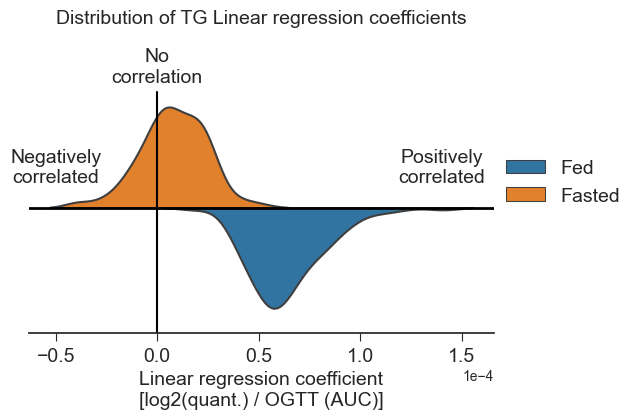

In [615]:
histdf = data.loc[data['molec_class'] == 'TG']
histdf = histdf.melt(value_vars=['coef_fed', 'coef_fasted'], var_name='bg_type', value_name='coef')
histdf['bg_type'] = histdf['bg_type'].map({'coef_fed': 'Fed', 'coef_fasted': 'Fasted'})
histdf['dummy'] = 0

fig, ax = plt.subplots(figsize=(6, 4), facecolor='white', dpi=100)

colors['Fed'] = colors['RBG']
colors['Fasted'] = colors['FBG']

sns.violinplot(
    data=histdf, y='dummy', x='coef', hue='bg_type', 
    split=True, orient='h', scale='count', inner=None,
#     linewidth=2, edgecolor='black', 
)
_min, _max = plt.xlim()
arrowprops=dict(arrowstyle='->', connectionstyle='angle3,angleA=90')
# plt.annotate(text='No\ncorrelation', xy=(0, -0.1), xytext=(-0.00005, -0.2), 
# #              arrowprops=arrowprops,
#              ha='center', fontsize=14)
# plt.annotate(text='Positively\ncorrelated', xy=(0.0001, -0.1), xytext=(0.00015, -0.2), 
# #              arrowprops=arrowprops, 
#              ha='center', fontsize=14)
# plt.annotate(text='Negatively\ncorrelated', xy=(-0.00004, 0.05), xytext=(-0.00005, 0.3), 
# #              arrowprops=dict(arrowstyle='->'), 
#              ha='center', va='top', fontsize=14)
# plt.scatter([-0.00001], [-0.2])

plt.ylim(-0.5, 0.7)
plt.text(0, 0.5, 'No\ncorrelation', fontsize=14, ha='center')
plt.text(0.00014, 0.1, 'Positively\ncorrelated', fontsize=14, ha='center')
plt.text(-0.00005, 0.1, 'Negatively\ncorrelated', fontsize=14, ha='center')
plt.axhline(0, c='black', linewidth=2)
plt.axvline(0, ymax=0.8, c='black')
plt.xticks(fontsize=14)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.xlabel('Linear regression coefficient\n[log2(quant.) / OGTT (AUC)]', fontsize=14)
plt.yticks([])
plt.ylabel(None)
plt.title('Distribution of TG Linear regression coefficients', fontsize=14)
plt.legend(markerscale=1.5, fontsize=14, loc=(1.01, 0.4))
sns.despine(left=True)

# plt.savefig(r'../reports/figures/TG_distribution_lin_reg_coefs/violin_plot_TGs.png', dpi=100, bbox_inches='tight')
# plt.savefig(r'../reports/figures/TG_distribution_lin_reg_coefs/violin_plot_TGs.svg', dpi=100, bbox_inches='tight')

## "approximately zero slope" can be made rigorous by looking for features with `qval_fed` and `qval_fasted > 0.05`

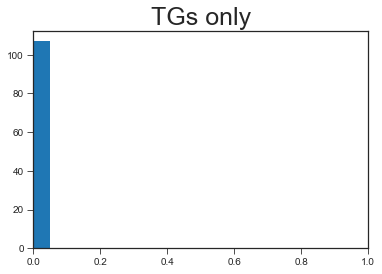

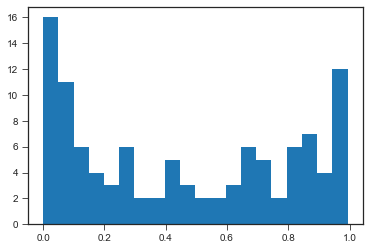

In [553]:
# Possible grouping #1:
#     Fasted approximately 0 slope, fed non-zero slope
#     Fasted non-zero slope, fed approximately 0 slope
#     Fasted and fed different slopes, both non-zero
#     Both have approximately 0 slopes

plt.hist(data.loc[data['molec_class'] == 'TG', 'qval_fed'], bins=np.arange(0, 1, 0.05))
plt.title('TGs only', fontsize=25)
plt.xlim(0, 1)
plt.figure()
plt.hist(data.loc[data['molec_class'] == 'TG', 'qval_fasted'], bins=20);

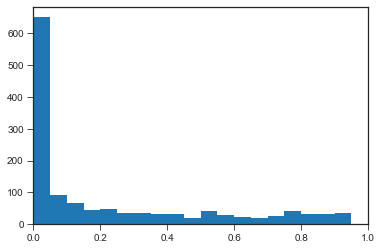

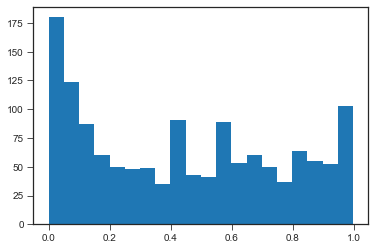

In [554]:
plt.hist(data.loc[:, 'qval_fed'], bins=np.arange(0, 1, 0.05))
plt.xlim(0, 1)
plt.figure()
plt.hist(data.loc[:, 'qval_fasted'], bins=20);

In [555]:
def parse_slope_trend(coef_fasted, coef_fed, qval_fasted, qval_fed):
    # There are 9 possible combinations of (+, 0, -) slopes:
    #     ['++', '+0', '+-', '0+', '00', '0-', '-+', '-0', '--']  
    #     pd.Series([''.join(x) for x in itertools.permutations('++00--', 2)]).unique()
    # SET CONVENTION AS FASTED 1ST, FED 2ND (because fasted-fed rolls off the tongue better than fed-fasted)
    
    if coef_fasted < 0: fasted_slope = '-'
    if coef_fasted > 0: fasted_slope = '+'
    if coef_fed < 0: fed_slope = '-'
    if coef_fed > 0: fed_slope = '+'
    
    # If the fit isn't significant, then we can't confirm whether the slope is truly predictive
    if qval_fasted > 0.1: fasted_slope = '0'
    if qval_fed    > 0.1: fed_slope    = '0'

    return fasted_slope + fed_slope
    
parse_slope_trend(10, -10, 0.00, 0.0)

'+-'

In [560]:
k['slope_trend'].value_counts()

0+    173
00     93
++     34
-0      5
-+      5
0-      3
--      2
+0      2
Name: slope_trend, dtype: int64

In [597]:
data['slope_trend'] = data[['coef_fasted', 'coef_fed', 'qval_fasted', 'qval_fed']] \
                        .apply(lambda x: parse_slope_trend(*x), axis=1)
data['fasted_trend'] = data['slope_trend'].str[0]
data['fed_trend'] = data['slope_trend'].str[1]

k = data.loc[(data['ID'] != 'unknown') & (data['Type'] == 'lipid')]  # k = knowns
trends = k['slope_trend'].value_counts()
# trends = k[['fasted_trend', 'fed_trend']].value_counts().to_frame().reset_index().rename({0: 'count'}, axis=1)
trends

0+    173
00     93
++     34
-0      5
-+      5
0-      3
--      2
+0      2
Name: slope_trend, dtype: int64

## With `slope_trend` figure out how to visualize membership of each lipid superclass (or lipid class) within each of the `+-` trends

### Use stacked barplot

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

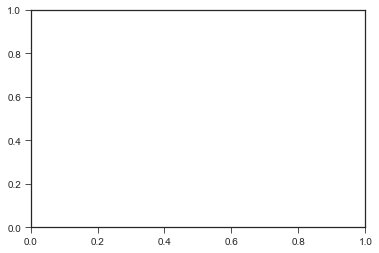

In [611]:
plt.xticks()

In [623]:
list(colors.values())[7:12]

[[0.5803921568627451, 0.403921568627451, 0.7411764705882353],
 [0.8392156862745098, 0.15294117647058825, 0.1568627450980392],
 [0.12156862745098039, 0.4666666666666667, 0.7058823529411765],
 [1.0, 0.4980392156862745, 0.054901960784313725],
 [0.17254901960784313, 0.6274509803921569, 0.17254901960784313]]

In [635]:
ax.get_xticklabels()[0].get_text()

'asdf'

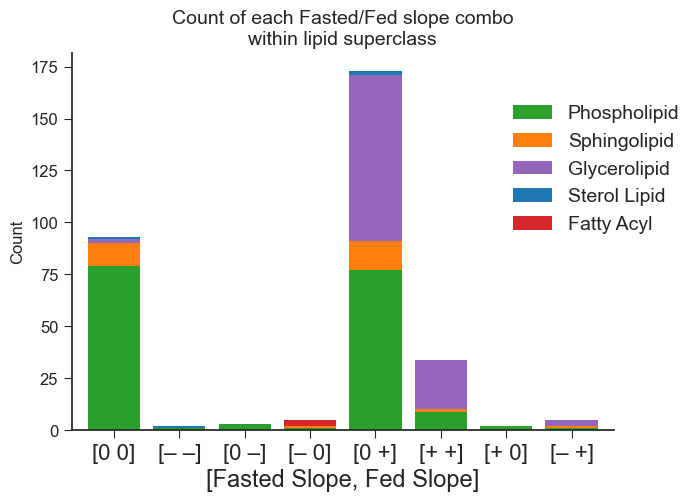

In [647]:
vcs = []
unique_trends = k['slope_trend'].unique()
for trend in unique_trends:
    df = k.loc[k['slope_trend'] == trend]
#     print(f'\nTREND: {trend}\n')
    vc = df['superclass'].value_counts()
#     print(vc)
    vcs.append(vc)
vcs = pd.DataFrame(vcs, index=unique_trends)
vcs.replace(np.nan, 0, inplace=True)

fig, ax = plt.subplots(figsize=(7, 5), facecolor='white', dpi=100)
vcs.plot(kind='bar', stacked=True, width=0.8, color=colors, ax=ax)
tick_labels = [x.get_text() for x in ax.get_xticklabels()]
tick_labels = [f'[{x[0]} {x[1]}]'.replace('-', '–') for x in tick_labels]
plt.xticks(ticks=plt.xticks()[0], labels=tick_labels, fontsize=16, rotation=0)   
plt.xlabel('[Fasted Slope, Fed Slope]', fontsize=17)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of each Fasted/Fed slope combo\nwithin lipid superclass', fontsize=14)
plt.legend(loc=(0.8, 0.5), fontsize=14)
sns.despine()

plt.savefig('../reports/figures/all_TG_plots/TG_slope_counts.svg', dpi=100, bbox_inches='tight')
plt.savefig('../reports/figures/all_TG_plots/TG_slope_counts.png', dpi=100, bbox_inches='tight')

,Phospholipid,Sphingolipid,Glycerolipid,Sterol Lipid,Fatty Acyl
superclass,79.0,11.0,2.0,1.0,NaN
superclass,1.0,NaN,NaN,1.0,NaN
superclass,3.0,NaN,NaN,NaN,NaN
superclass,1.0,1.0,NaN,NaN,3.0
superclass,77.0,14.0,80.0,2.0,NaN
superclass,9.0,1.0,24.0,NaN,NaN
superclass,2.0,NaN,NaN,NaN,NaN
superclass,1.0,1.0,3.0,NaN,NaN


KeyboardInterrupt: 

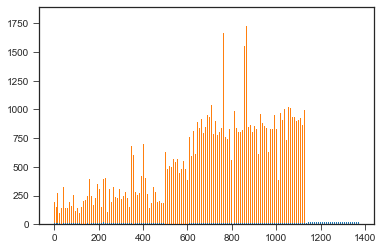

In [538]:
data.plot(kind='bar', stacked=True)

In [537]:
sns.barplot(
    data=data.loc[data['ID'] != 'unknown'], y='slope_trend', 
)

TypeError: Vertical orientation requires numeric `y` variable.

In [220]:
# Define what "nearly zero slope" means based on the above distribution 
#     -0.000015 to 0.000015 seems like a good range 

print('num. signif. sampling metabolites in fed with approx. 0 slope: ', 
      len(isdf.loc[(isdf['r_coef'] > -0.00001) & (isdf['r_coef'] < 0.00001)]))
print('num. signif. sampling metabolites in fasted with approx. 0 slope: ', 
      len(isdf.loc[(isdf['f_coef'] > -0.00001) & (isdf['f_coef'] < 0.00001)]))

num. signif. sampling metabolites in fed with approx. 0 slope:  50
num. signif. sampling metabolites in fasted with approx. 0 slope:  214


In [226]:
def get_approx_zero(slope, cutoff=0.00001):
    if -cutoff < slope < cutoff:
        return 'zero'
    else:
        return 'nonzero'
    
data['r_slope_zero'] = data['r_coef'].apply(get_approx_zero)
data['f_slope_zero'] = data['f_coef'].apply(get_approx_zero)

In [231]:
data['both zero'] = (data['r_slope_zero'] == 'zero') & (data['f_slope_zero'] == 'zero')
data['both nonzero'] = (data['r_slope_zero'] == 'nonzero') & (data['f_slope_zero'] == 'nonzero')
data['fed nonzero fasted zero'] = (data['r_slope_zero'] == 'nonzero') & (data['f_slope_zero'] == 'zero')
data['fed zero fasted nonzero'] = (data['r_slope_zero'] == 'nonzero') & (data['f_slope_zero'] == 'nonzero')

In [237]:
data.loc[data['both nonzero'], ['Type', 'RT', 'm/z', 'molec_class', 'ID']]

,RT,m/z,molec_class,ID
i,,,,
m_0,2.353,141.06591,NaN,unknown
m_4,12.732,167.02007,NaN,Uric acid
m_19,12.855,257.05402,NaN,unknown
m_20,7.922,144.10199,NaN,Stachydrine
m_33,7.453,192.06573,NaN,Phenylacetylglycine
...,...,...,...,...
l_867,19.882,1001.92316,unknown,unknown
l_869,20.144,948.89648,unknown,unknown
l_870,20.148,897.82532,unknown,unknown


In [239]:
fed_nonzero = data.loc[(data['Type'] == 'lipid') & (data['fed nonzero fasted zero']),
         ['Type', 'RT', 'm/z', 'molec_class', 'ID']]

,Type,RT,m/z,molec_class,ID
i,,,,,
l_3,lipid,0.876,631.34955,unknown,unknown
l_6,lipid,1.095,496.33994,LysoPC,LysoPC 16:0
l_9,lipid,1.289,568.33972,LysoPC,LysoPC 22:6
l_11,lipid,1.332,544.33984,LysoPC,LysoPC 20:4
l_22,lipid,1.489,496.34018,LysoPC,LysoPC 16:0
...,...,...,...,...,...
l_860,lipid,19.574,931.88068,unknown,unknown
l_861,lipid,19.582,946.88043,TG,TG 57:2
l_862,lipid,19.840,975.90753,unknown,unknown


In [172]:
# Another possible grouping #2:

#     True if |Fed slope| > |Fasted slope| else False
#     |Fed slope| > |fasted slope|

isdf['group2'] = isdf.loc[:, ['r_coef', 'f_coef']].apply(lambda x: abs(x[0]) > abs(x[1]), axis=1)
print('number of |fed slopes| > |fasted slopes|:', isdf['group2'].sum())

number of |fed slopes| > |fasted slopes|: 415


C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# Another grouping #3:

#     Both slopes positively correlate with OGTT
#     Both slopes negatively correlate with OGTT
#     Fasted is positive and fed is negative
#     Fed is positive and fasted is negative

def group3(row):
    rbg_slope = row[0]
    fbg_slope = row[1]
    if rbg_slope > 0 and fbg_slope > 0:
        return 'both pos'
    elif rbg_slope < 0 and fbg_slope < 0:
        return 'both neg'
    elif rbg_slope > 0 and fbg_slope < 0:
        return 'fed pos, fasted neg'
    elif rbg_slope < 0 and fbg_slope > 0:
        return 'fed neg, fasted pos'
    
isdf['group3'] = isdf[['fit_rbg_slope', 'fit_fbg_slope']].apply(lambda x: group3(x), axis=1)
isdf['group3'].value_counts()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fed pos, fasted neg    295
both pos               198
both neg                20
fed neg, fasted pos      2
Name: group3, dtype: int64

## 2 metabolites buck the trend and have Fed=negative slope, Fasted=positive slope
1. m_625 = unknown
2. l_150 = PC 38:7 

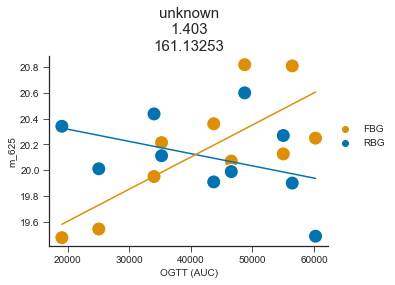

<Figure size 432x288 with 0 Axes>

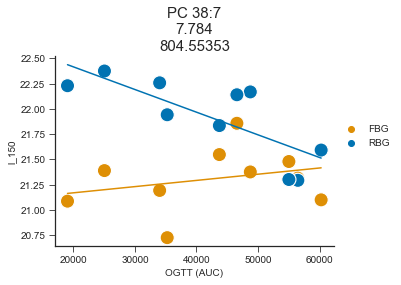

In [31]:
plot_mean_fits('m_625')
plt.figure()
plot_mean_fits('l_150')

### When both fed and fasted have negative slopes, all 20 are metabolites, none are lipids 

In [32]:
isdf.loc[isdf['group3'] == 'both neg']

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_rbg_slope,fit_fbg_slope,fit_rbg_line,fit_fbg_line,group2,group3
i,,,,,,,,,,,,,,,,,,,,,
m_7,Trigonelline_9.139_138.05502,9.139,138.05502,[M+H]+1,metabolite,+,Trigonelline,23.547123,23.325673,21.397206,...,23.439491,23.140544,22.541140,21.458955,-7.258624e-06,-0.000026,"[[19060.0, 60245.0], [23.43949093146824, 23.14...","[[19060.0, 60245.0], [22.541139966280504, 21.4...",False,both neg
m_26,Pyroglutamic acid_12.646_147.07649,12.646,147.07649,[M+NH4]+1,metabolite,+,Pyroglutamic acid,26.772092,26.967102,26.878423,...,26.891816,26.880453,27.299172,26.730098,-2.758880e-07,-0.000014,"[[19060.0, 60245.0], [26.891815543955676, 26.8...","[[19060.0, 60245.0], [27.299171987351443, 26.7...",False,both neg
m_56,unknown_12.63_181.0376,12.630,181.03760,[M-H]-1,metabolite,-,unknown,19.684059,20.102916,19.484556,...,19.815779,19.745888,20.227855,19.478691,-1.697016e-06,-0.000018,"[[19060.0, 60245.0], [19.815779243105066, 19.7...","[[19060.0, 60245.0], [20.22785490450404, 19.47...",False,both neg
m_60,unknown_9.881_148.04271,9.881,148.04271,[M-H]-1,metabolite,-,unknown,20.768966,20.237077,18.838112,...,20.467013,20.451334,20.394726,19.035477,-3.806921e-07,-0.000033,"[[19060.0, 60245.0], [20.467012533301727, 20.4...","[[19060.0, 60245.0], [20.394726366427797, 19.0...",False,both neg
m_61,unknown_12.828_133.06088,12.828,133.06088,[M+NH4]+1,metabolite,+,unknown,23.025060,22.598590,21.784341,...,22.756975,22.713120,22.528477,21.717179,-1.064846e-06,-0.000020,"[[19060.0, 60245.0], [22.756975352074086, 22.7...","[[19060.0, 60245.0], [22.52847672230808, 21.71...",False,both neg
m_207,unknown_8.572_176.1394,8.572,176.13940,[M+H]+1,metabolite,+,unknown,23.086674,23.175012,22.828974,...,23.221583,22.785719,23.511558,22.616625,-1.058308e-05,-0.000022,"[[19060.0, 60245.0], [23.221583352657746, 22.7...","[[19060.0, 60245.0], [23.51155769561644, 22.61...",False,both neg
m_220,Betaine_8.574_118.08656,8.574,118.08656,[M+H]+1,metabolite,+,Betaine,27.560760,27.630282,27.304524,...,27.712101,27.270041,27.967044,27.128216,-1.073351e-05,-0.000020,"[[19060.0, 60245.0], [27.712100882831514, 27.2...","[[19060.0, 60245.0], [27.96704427171678, 27.12...",False,both neg
m_225,unknown_12.845_131.04513,12.845,131.04513,[M-H]-1,metabolite,-,unknown,24.226682,24.031969,23.093844,...,24.109834,24.045749,23.857004,23.033745,-1.556047e-06,-0.000020,"[[19060.0, 60245.0], [24.109834386339557, 24.0...","[[19060.0, 60245.0], [23.857003609044142, 23.0...",False,both neg
m_226,Asparagine_12.852_133.06101,12.852,133.06101,[M+H]+1,metabolite,+,Asparagine,23.025060,22.592129,21.781089,...,22.747098,22.701390,22.514098,21.685732,-1.109834e-06,-0.000020,"[[19060.0, 60245.0], [22.747098324787494, 22.7...","[[19060.0, 60245.0], [22.514098159363908, 21.6...",False,both neg


In [33]:
# Hard to draw a conclusion from these value counts
isdf.loc[isdf['group3'] == 'fed pos, fasted neg', 'molec_class'].value_counts()

unknown         109
TG               29
PC               15
SM                4
Plasmenyl-PE      4
Plasmanyl-PE      4
Cer[NS]           4
Plasmanyl-PC      3
PI                1
Plasmenyl-PC      1
CE                1
Name: molec_class, dtype: int64

In [245]:
# Only m_602 unknown metabolite has both positive slopes, but rbg_slope < fbg_slope
isdf.loc[(isdf['fit_rbg_slope'] < isdf['fit_fbg_slope'])\
         & (isdf['fit_rbg_slope'] > 0)
        ]

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_fbg_slope,fit_rbg_line,fit_fbg_line,fit_rbg_slope,group2,group3
i,,,,,,,,,,,,,,,,,,,,,
m_602,unknown_2.576_107.04886,2.576,107.04886,[M-H]-1,metabolite,-,unknown,16.800285,16.610097,21.571233,...,16.518861,16.899642,19.545776,21.4031,0.000045,"[[19060.0, 60245.0], [16.51886050148695, 16.89...","[[19060.0, 60245.0], [19.545775967655764, 21.4...",0.000009,False,both pos


In [247]:
isdf.loc[(isdf['fit_rbg_slope'] < isdf['fit_fbg_slope']) & (isdf['molec_class'] == 'TG')]

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_fbg_slope,fit_rbg_line,fit_fbg_line,fit_rbg_slope,group2,group3
i,,,,,,,,,,,,,,,,,,,,,


## 'Both slopes positive' enriches for TGs 
### None of the TGs under 'both slopes positive' have fasted slope > fed slope
### suggesting that TGs uniformly increase more with ogtt auc while Random-fed than while fasted 

In [92]:
def parse_pval(pval):
    if pval < 0.0001:
        return '****'
    if pval < 0.001:
        return '***'
    if pval < 0.01:
        return '**'
    if pval < 0.05: 
        return '*'
    else:
        return 'ns'

In [129]:
data['superclass'].unique()

array(['Unidentified', 'Identified_metabolite', 'Phospholipid',
       'Fatty Acyl', 'Glycerolipid', 'Sphingolipid', 'Sterol Lipid'],
      dtype=object)

In [116]:
data['molec_class'] = data['molec_class'].replace(np.nan, 'unknown')
data['molec_class'].unique()

array(['unknown', 'LysoPC', 'LysoPE', 'AC', 'PC', 'Alkenyl-DG', 'PI',
       'SM', 'Plasmenyl-PC', 'Plasmanyl-PC', 'Plasmenyl-PE', 'PE',
       'Plasmanyl-PE', 'Cer[NS]', 'TG', 'CE'], dtype=object)

In [117]:
data['superclass'] = data['molec_class'].map(lambda x: colors[x]['superclass'])

In [128]:
data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'unknown'), 'superclass'] = 'Identified_metabolite'

In [149]:
for i, feature in enumerate(data.index):
    print(i)
    superclass = data.loc[feature, 'superclass']
    _type = data.loc[feature, 'Type']
    if superclass == 'Unidentified':
        superclass = superclass + '_' + _type
#     else:
#         subpath = ''
#     if superclass == 'Unidentified'
    folder_path = f'../reports/figures/all_metabolite_plots/{superclass}'
    make_fit_plot(feature=feature, folder_path=folder_path, file_type='png', savefig=True)
#     if i == 5:
#         break
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_slopes(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_332', data)
test

{'RBG': [[19060.0, 60245.0], [39.362305205317945, 90.60244106092115]],
 'FBG': [[19060.0, 60245.0], [37.079582242394736, 79.00802709159697]]}

In [ ]:
def plot_mean_fits(feature):
    fig, ax = plt.subplots(figsize=(5, 3.5))
    sns.scatterplot(
        data=mean_within_animal_sampling, x='OGTT (AUC)', y=feature,
        hue='bg_type', s=200, palette=colors, ax=ax)
    plt.plot(*fit_cols.loc[feature, 'fit_rbg_line'], color=colors['RBG'])
    plt.plot(*fit_cols.loc[feature, 'fit_fbg_line'], color=colors['FBG'])
    plt.legend(loc=(1.01, 0.5))
    plt.title('\n'.join(data.loc[feature, ['ID', 'RT', 'm/z']].astype('str').to_list()), fontsize=15)
    sns.despine()
feature = 'l_648'
plot_mean_fits(feature)